In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

import xgboost as xgb

from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    print(classification_report(y_test, pred, target_names=emo_keys))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [3]:
audio_x_test = pd.read_csv('data/s2e/audio_test.csv')
y_test = audio_x_test['label']

In [4]:
audio_x_test.head()

,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses05M_script01_3_M018,4,0.011065,0.019146,0.011708,0.034076,0.794471,0.170637,0.000634,0.000395
1,Ses01F_script03_1_M002,3,0.008862,0.012417,0.008954,0.020354,0.005397,0.170743,0.000266,0.000292
2,Ses04M_script03_1_M001,3,0.044710,0.059493,0.045739,0.086141,0.485995,0.171813,0.004845,0.002111
3,Ses02F_script03_1_F000,3,0.017400,0.024265,0.018270,0.037164,0.578112,0.172077,0.000897,0.000624
4,Ses02F_impro05_F006,0,0.049168,0.060384,0.051481,0.078107,0.320240,0.171321,0.004737,0.003620


In [5]:
audio_x_test.set_index("wav_file").index[:5]

Index(['Ses05M_script01_3_M018', 'Ses01F_script03_1_M002',
       'Ses04M_script03_1_M001', 'Ses02F_script03_1_F000',
       'Ses02F_impro05_F006'],
      dtype='object', name='wav_file')

In [6]:
df = pd.read_csv('data/t2e/text_train.csv')
df = df.append(pd.read_csv('data/t2e/text_test.csv'))

In [7]:
df.head()

,wav_file,label,transcription
0,Ses01F_script01_3_M014,4,you felt something that far back ?
1,Ses01M_script01_1_F010,4,what ?
2,Ses02F_script03_2_F043,0,thank god i realized what you are i d never ma...
3,Ses05F_impro02_M039,4,three weeks ?
4,Ses02M_script02_2_F031,2,well but this isn t anything like i thought an...


In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

tfidf.fit(df.transcription)
features = tfidf.transform(df.transcription).toarray()

print(features.shape)

(67528, 2606)


In [9]:
text_x = pd.DataFrame(features, index=df.wav_file).reset_index().drop_duplicates()
text_x

,wav_file,0,1,2,3,4,5,6,7,8,...,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605
0,Ses01F_script01_3_M014,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ses01M_script01_1_F010,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ses02F_script03_2_F043,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ses05F_impro02_M039,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ses02M_script02_2_F031,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67468,Ses04F_impro07_F006,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67469,Ses02M_script02_1_M029,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67480,Ses05F_impro07_F027,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67493,Ses02M_script01_3_M032,0.0,0.0,0.0,0.0,0.0,0.230644,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
x_test_wav = pd.DataFrame(audio_x_test["wav_file"])
x_test_wav

,wav_file
0,Ses05M_script01_3_M018
1,Ses01F_script03_1_M002
2,Ses04M_script03_1_M001
3,Ses02F_script03_1_F000
4,Ses02F_impro05_F006
...,...
13501,Ses01F_script03_1_F002
13502,Ses05M_impro02_F015
13503,Ses04F_impro04_M017
13504,Ses03M_impro03_F002


In [11]:
text_x = x_test_wav.merge(text_x, how="left", on="wav_file")
text_x_test = text_x.drop("wav_file", 1)
text_x_test_wav = text_x["wav_file"]
del text_x
del df
del features
del tfidf

In [12]:
text_x_test

,0,1,2,3,4,5,6,7,8,9,...,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
with open('trained_models/t2e/RF.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)

In [18]:
with open('trained_models/t2e/RF.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)

pred_probs = rf_classifier.predict_proba(text_x_test)

with open('pred_probas/text_rf_classifier2.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [19]:
with open('trained_models/t2e/XGB.pkl', 'rb') as f:
    xgb_classifier = pickle.load(f)

pred_probs = xgb_classifier.predict_proba(text_x_test)

with open('pred_probas/text_xgb_classifier2.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [20]:
with open('trained_models/t2e/MNB.pkl', 'rb') as f:
    mnb_classifier = pickle.load(f)

pred_probs = mnb_classifier.predict_proba(text_x_test)

with open('pred_probas/text_mnb_classifier2.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [21]:
with open('trained_models/t2e/MLP.pkl', 'rb') as f:
    mlp_classifier = pickle.load(f)

pred_probs = mlp_classifier.predict_proba(text_x_test)

with open('pred_probas/text_mlp_classifier2.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [22]:
with open('trained_models/t2e/LR.pkl', 'rb') as f:
    lr_classifier = pickle.load(f)

pred_probs = lr_classifier.predict_proba(text_x_test)

with open('pred_probas/text_lr_classifier2.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [26]:
# Text Classifiers
with open('pred_probas/text_rf_classifier2.pkl', 'rb') as f:
    text_rf_pred_probs = pickle.load(f)

with open('pred_probas/text_xgb_classifier2.pkl', 'rb') as f:
    text_xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_mnb_classifier2.pkl', 'rb') as f:
    text_mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_mlp_classifier2.pkl', 'rb') as f:
    text_mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/text_lr_classifier2.pkl', 'rb') as f:
    text_lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
text_e2_pred_probs = (text_xgb_pred_probs + text_mlp_pred_probs + 
                      text_rf_pred_probs + text_mnb_pred_probs +
                      text_lr_pred_probs) / 5.0

In [29]:
# Audio Classifiers
with open('pred_probas/rf_classifier.pkl', 'rb') as f:
    audio_rf_pred_probs = pickle.load(f)

with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    audio_xgb_pred_probs = pickle.load(f)

with open('pred_probas/mlp_classifier.pkl', 'rb') as f:
    audio_mlp_pred_probs = pickle.load(f)

audio_e1_pred_probs = (audio_xgb_pred_probs + audio_mlp_pred_probs
                       + audio_rf_pred_probs) / 3.0

In [33]:
late_fusion1_pred_probs = (text_e2_pred_probs + audio_e1_pred_probs) / 2.0
late_fusion2_pred_probs = (text_e2_pred_probs + audio_rf_pred_probs) / 2.0

Test Set Accuracy =  0.958
Test Set F-score =  0.790
Test Set Precision =  0.872
Test Set Recall =  0.743
              precision    recall  f1-score   support

         ang       0.85      0.49      0.62       241
         hap       0.93      0.67      0.78       360
         sad       0.70      0.80      0.75       633
         fea       0.98      1.00      0.99      8972
         sur       0.97      1.00      0.98      2898
         neu       0.81      0.50      0.62       402

    accuracy                           0.96     13506
   macro avg       0.87      0.74      0.79     13506
weighted avg       0.96      0.96      0.95     13506

Confusion matrix, without normalization
[[ 117    5   66   34   11    8]
 [   0  242   43   30   24   21]
 [  15    2  506   64   27   19]
 [   0    0    0 8972    0    0]
 [   0    0    0    0 2898    0]
 [   6   11  109   39   35  202]]


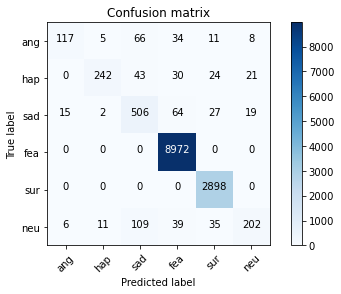

In [32]:
display_results(y_test, late_fusion1_pred_probs)

Test Set Accuracy =  0.961
Test Set F-score =  0.794
Test Set Precision =  0.866
Test Set Recall =  0.755
              precision    recall  f1-score   support

         ang       0.83      0.51      0.63       241
         hap       0.94      0.64      0.76       360
         sad       0.68      0.85      0.75       633
         fea       0.99      1.00      0.99      8972
         sur       0.98      1.00      0.99      2898
         neu       0.79      0.53      0.63       402

    accuracy                           0.96     13506
   macro avg       0.87      0.76      0.79     13506
weighted avg       0.96      0.96      0.96     13506

Confusion matrix, without normalization
[[ 123    3   75   21    9   10]
 [   2  231   62   22   13   30]
 [  16    2  537   45   15   18]
 [   0    0    0 8972    0    0]
 [   0    0    0    0 2898    0]
 [   8   11  116   31   23  213]]


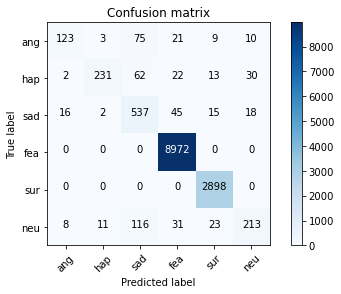

In [34]:
display_results(y_test, late_fusion2_pred_probs)